In [1]:
import os
import numpy as np
import json
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation
import matplotlib.pyplot as plt
##import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model
import sklearn
from sklearn.ensemble import RandomForestRegressor



pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [9]:
data_df = pd.read_csv(os.path.join('data.csv'))

In [ ]:
with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

In [ ]:
data_df

In [ ]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [ ]:
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'S'))
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'W'))

In [ ]:
Counter(data_df.deck_format)

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data_df.craft_cost, np.sort(data_df.rating.values))
plt.xlabel('rating', fontsize=12)
plt.ylabel('craft_cost', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data_df.craft_cost, np.sort(data_df.rating.values))
plt.xlabel('rating', fontsize=12)
plt.ylabel('craft_cost', fontsize=12)
plt.show()

In [ ]:
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Priest'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Warrior'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Mage'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Druid'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Warlock'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Hunter'))
print np.average(data_df.craft_cost, weights=(data_df.deck_class == 'Rogue'))

In [ ]:
info_df = data_df.ix[:,0:11]

In [ ]:
info_df.head()

In [ ]:
Counter(data_df.deck_type)

In [ ]:
Counter(refs.race)

# Releases and meta

## Race

In [2]:
data_df = pd.read_csv(os.path.join('~/', 'Desktop','random code','portfolio','hearthstone', 'data.csv'))

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

data_df['date'] = pd.to_datetime(data_df['date'])
refs.race.fillna('Normal', inplace=True)
data_df = data_df.drop(data_df.deck_type == 'Tavern Brawl')
refs.cost.fillna(0,inplace=True)

card_col = ['card_{}'.format(str(i)) for i in range(30)]

In [3]:
result = data_df
result = result.reset_index(drop = True)

for x in range(30):
    result = pd.merge(result, refs, left_on = result[card_col[x]], right_on = refs.dbfId, how = 'left')

In [4]:
## creating Race columns and its sum

races = refs.race.unique()
race_df = pd.DataFrame(index=result.index)
for x in range(len(races)):
    race_df[races[x]] = 0
    
dum = [result['race_x'],result['race_y']]
    
for x in range(len(result)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(races)):
        race_df = race_df.set_value(x, races[i], out[races[i]])

In [5]:
race_df['date'] = result.date
race_df['deck_set'] = result.deck_set

In [40]:
rand_ex = race_df[race_df.deck_set == 'Explorers']
rand_og = race_df[race_df.deck_set == 'Old Gods']
rand_br = race_df[race_df.deck_set == 'Blackrock Launch']
rand_gadge = race_df[race_df.deck_set == 'Gadgetzan']
rand_kar = race_df[race_df.deck_set == 'Karazhan']
rand_naxx = race_df[race_df.deck_set == 'Naxx Launch']
rand_tgt = race_df[race_df.deck_set == 'TGT Launch']
rand_gvg = race_df[race_df.deck_set == 'GVG Launch']

race_df_groupby = race_df.groupby('deck_set')

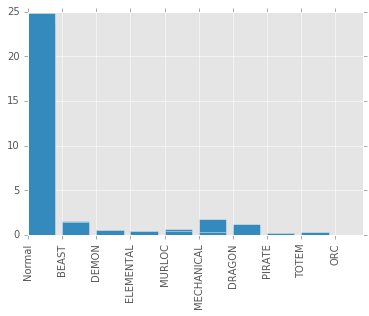

In [19]:
a = range(len(rand_ex.sum()))
b = rand_ex.mean()
plt.bar(a, b)

x = range(len(rand_og.sum()))
y = rand_og.mean()
my_xticks = rand_og.columns
plt.xticks(x, my_xticks, rotation = 'vertical')
plt.bar(x, y)


plt.show()



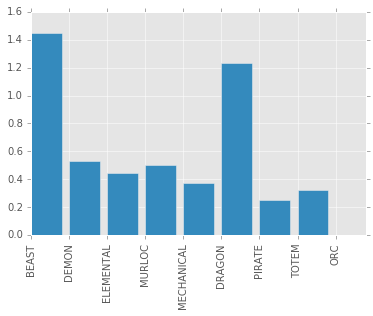

In [33]:
lol = rand_og.drop('Normal', axis = 1)

x = range(len(lol.sum()))
y = lol.mean()
my_xticks = lol.columns
plt.xticks(x, my_xticks, rotation = 'vertical')
plt.bar(x, y)


plt.show()


In [ ]:
lol = rand_og.drop('Normal', axis = 1)

x = range(len(lol.sum()))
y = lol.mean()
my_xticks = lol.columns
plt.pie(x, y)


plt.show()


In [ ]:
print 'hi'

In [ ]:
data_df.columns

In [ ]:
refs.columns